In [1]:
import os, sys
%load_ext autoreload
%autoreload 2

print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

from BalloonModelNetwork2 import generateConnectivityMatrix, generateNetworkEvents, BalloonModel

plt.close('all')

Nsamples = 300
TR = 1
Nnds = 10 # This is the number of nodes
Nconn = 10 # This is the number of connections (assigned randomly) 

timeline = TR * np.arange( Nsamples )
C = generateConnectivityMatrix(Nnds, Nconn)
U = generateNetworkEvents(timeline, Nnds, nblocks=5, duration_range=(1,1))


bm = BalloonModel(timeline, U, C)

bm.StimulusToNeural()
bm.NeuraltoFlowin()
bm.FlowinToBold()
bm.add_noise()

bm.plot_signals(which_one='neural', add_events=True)
bm.plot_signals(which_one='flow in', add_events=True)
bm.plot_signals(which_one='vascular', add_events=True)
bm.plot_signals(which_one='q(t)', add_events=True)
bm.plot_signals(which_one='v(t)', add_events=True)
bm.plot_signals(which_one='BOLD', add_events=True)
bm.plot_signals(which_one='BOLD noisy', add_events=True)



# plot_signals(timeline, bm.u, title='events')

# bm.StimulusToNeural()
# plot_signals(bm.tneural, bm.neural, title='neural')

# bm.NeuraltoFlowin()
# plot_signals(bm.t_flowin_vascular, bm.flowin, title='flow in')
# plot_signals(bm.t_flowin_vascular, bm.vascular, title='vascular')

# bm.FlowinToBold()
# plot_signals(bm.t_bold, bm.bold, title='BOLD')
# plot_signals(bm.t_bold, bm.q_signal, title='q(t)')
# plot_signals(bm.t_bold, bm.v_signal, title='v(t)')

/Users/aveloz/miniconda3


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

ValueError: x and y must have same first dimension, but have shapes (300,) and (2,)

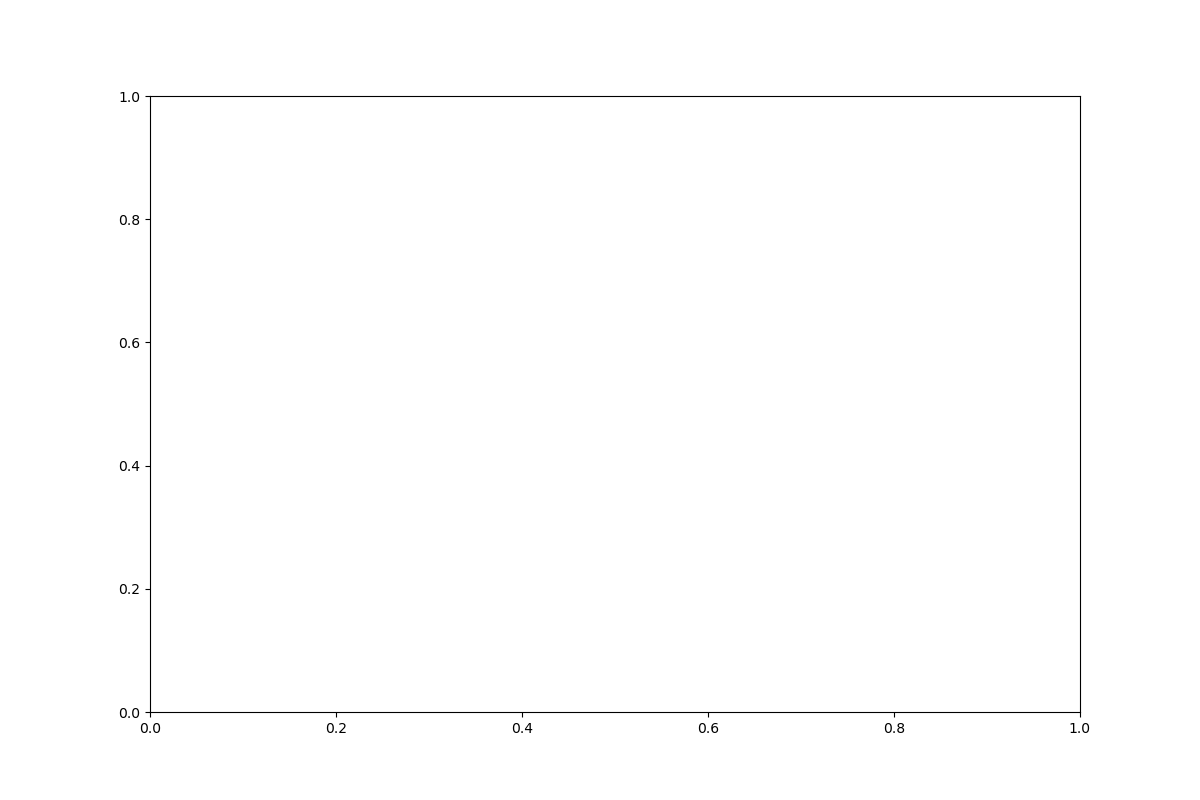

In [ ]:
import numpy as np
from scipy.integrate import odeint

def balloon_model(t, y, params):
    """
    Implement the Balloon model differential equations.
    
    state: [f, v, q]
    t: time point
    u_func: input function (neuronal activity)
    params: dictionary of model parameters
    """
    f, v, q = y
    
    # Extract parameters
    E0 = params['E0']
    tau0 = params['tau0']
    alpha = params['alpha']
    tau = params['tau']
    u_func = params['u_func']
    
    # Calculate u(t) for the current time point
    u = u_func(t)
    
    # Equations
    dfdt = u - (f - 1) / tau0
    dvdt = (f - v**(1/alpha)) / tau
    dqdt = (f * (1 - (1-E0)**(1/f)) / E0 - q*v**(1/alpha-1)) / tau
    
    return [dfdt, dvdt, dqdt]

def bold_signal(v, q, params):
    """Calculate BOLD signal"""
    V0 = params['V0']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    
    return V0 * (k1 * (1 - q) + k2 * (1 - q/v) + k3 * (1 - v))

# Define input function (e.g., boxcar function)
def u_func(t):
    return 1.0 if 1 <= t <= 1.1 else 0.0


# Set up parameters
params = {
    'E0': 0.4,
    'tau0': 2.0,
    'alpha': 0.4,
    'tau': 2.0,
    'V0': 0.03,
    'k1': 7 * 0.02,
    'k2': 2,
    'k3': 2 * 0.02 - 0.2,
    'u_func': u_func
}


# Create time array
t = np.linspace(0, 30, 300)

# Initial conditions
initial_state = [1.0, 1.0, 1.0]  # [f, v, q]

# Solve ODE
solution = odeint(balloon_model, t, initial_state, args=(params,))
solution.shape
# # Extract solutions
flowin = solution[0,:]
v = solution[1,:]
q = solution[2,:]

# Calculate BOLD signal
y = bold_signal(v, q, params)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(t, flowin, label='Blood flow (f)')
plt.plot(t, v, label='Blood volume (v)')
plt.plot(t, q, label='Deoxyhemoglobin (q)')
plt.plot(t, y, label='BOLD signal (y)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized units')
plt.title('Balloon Model Dynamics')
plt.legend()
plt.grid(True)
plt.show()